In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

#import
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Data Cleaning


In [2]:
# detect the face ond eyes ond crop that imgage and store it in some different folder
img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/mariasharapova/mariasharapova.jpg")

In [3]:
img.shape

(731, 1300, 3)

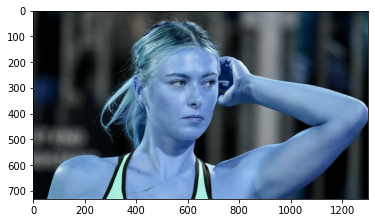

In [4]:
plt.imshow(img)

In [5]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape

(731, 1300)

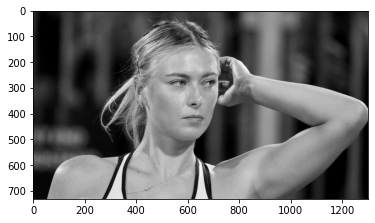

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
# to detect face and eyes of any image so that we can crop those images
# haar Cascade Classifier
face_cascade = cv2.CascadeClassifier('/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/haarcascades/haarcascade_eye.xml')


In [8]:
faces=face_cascade.detectMultiScale(gray,1.1,3,5)
faces

array([[399,  99,  73,  73],
       [469, 157, 316, 316]], dtype=int32)

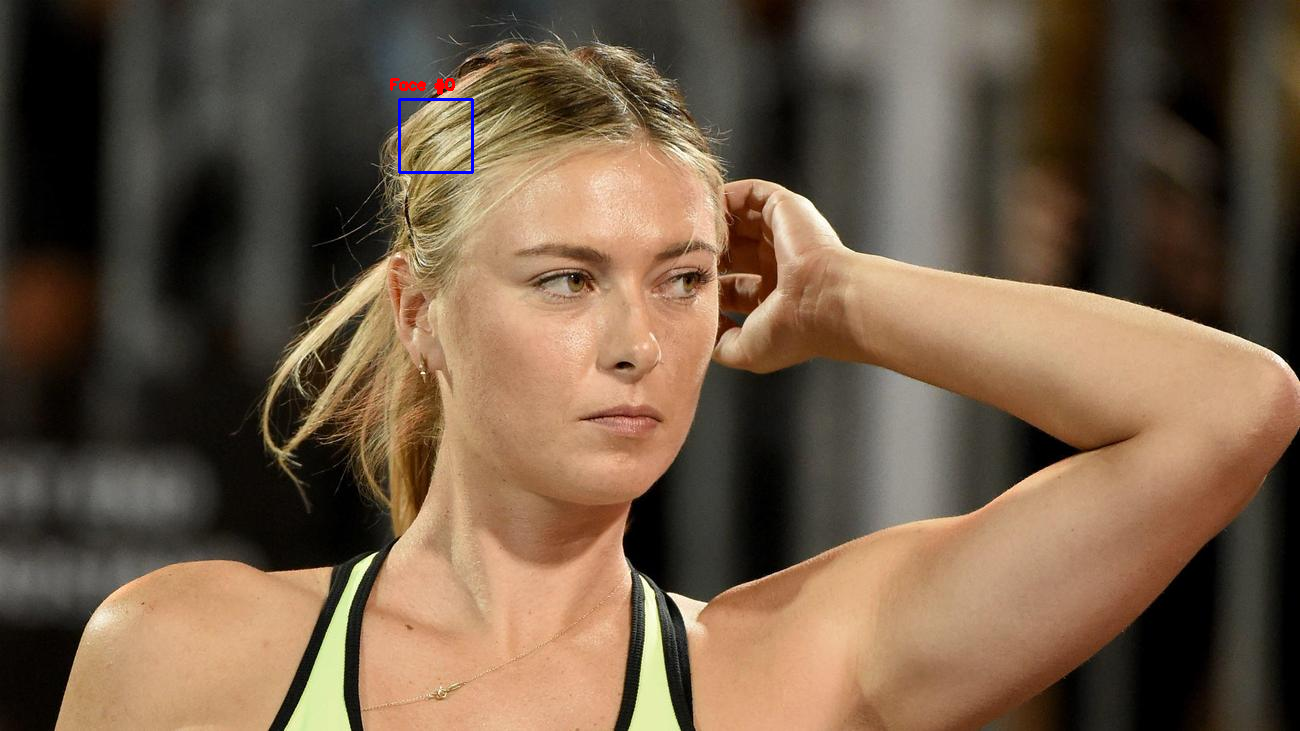

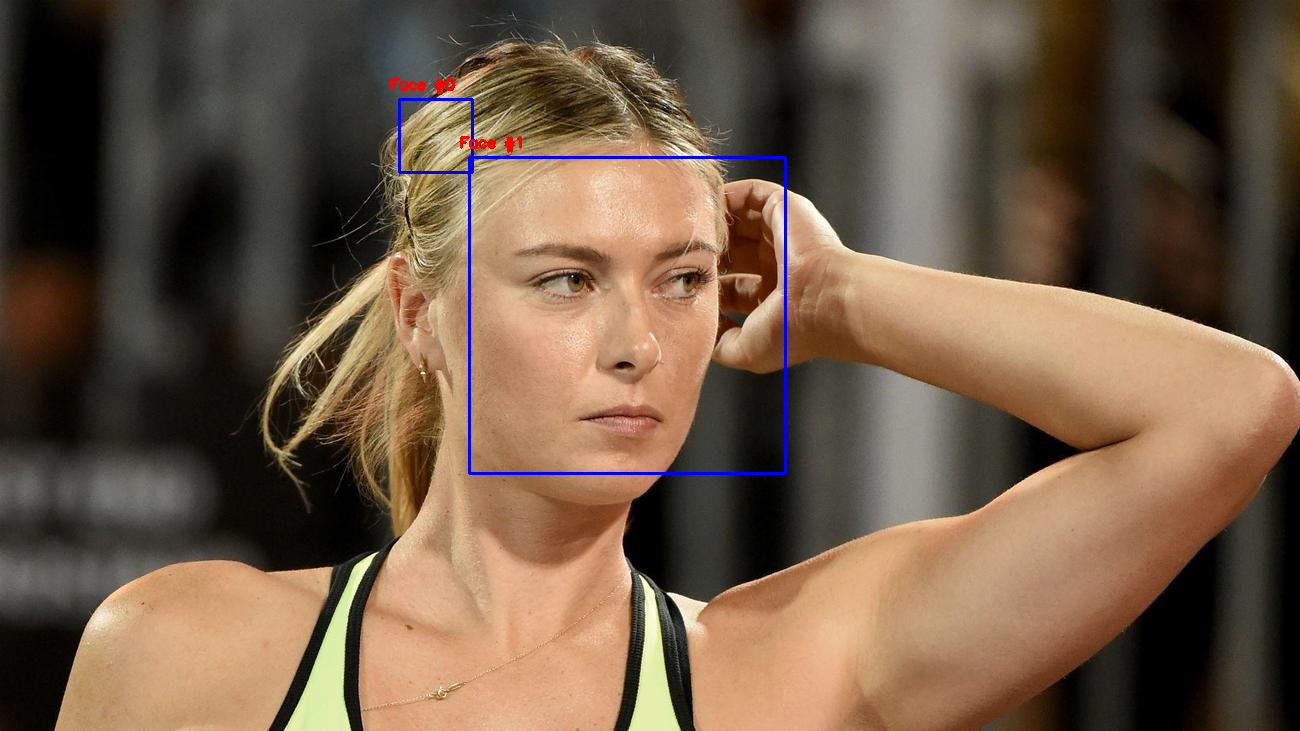

In [9]:
# FACES
if len(faces) >= 1:
    i = 0
    for f in faces:
        face = faces[i]
        (x, y, w, h) = face
        face_img= cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        cv2.putText(img, "Face #{}".format(i), (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        i = i + 1
        cv2_imshow(face_img)

In [10]:
cv2.destroyAllWindows()

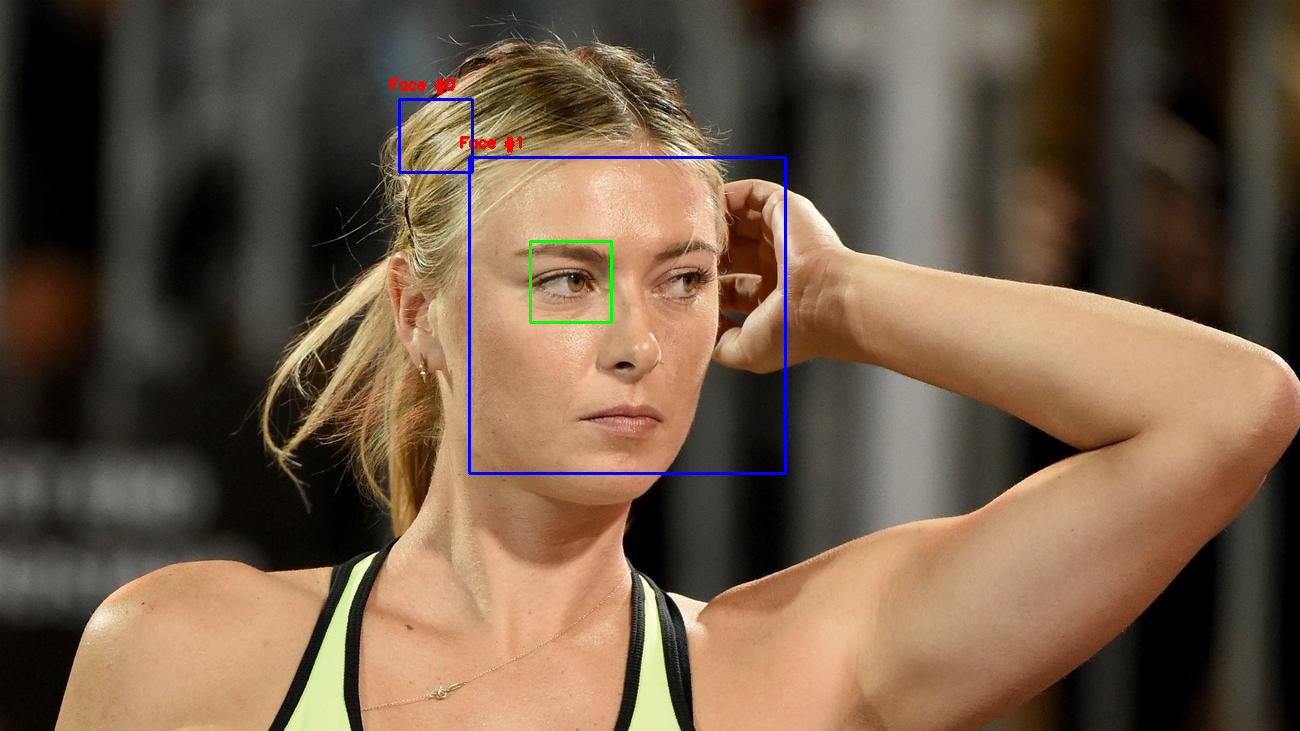

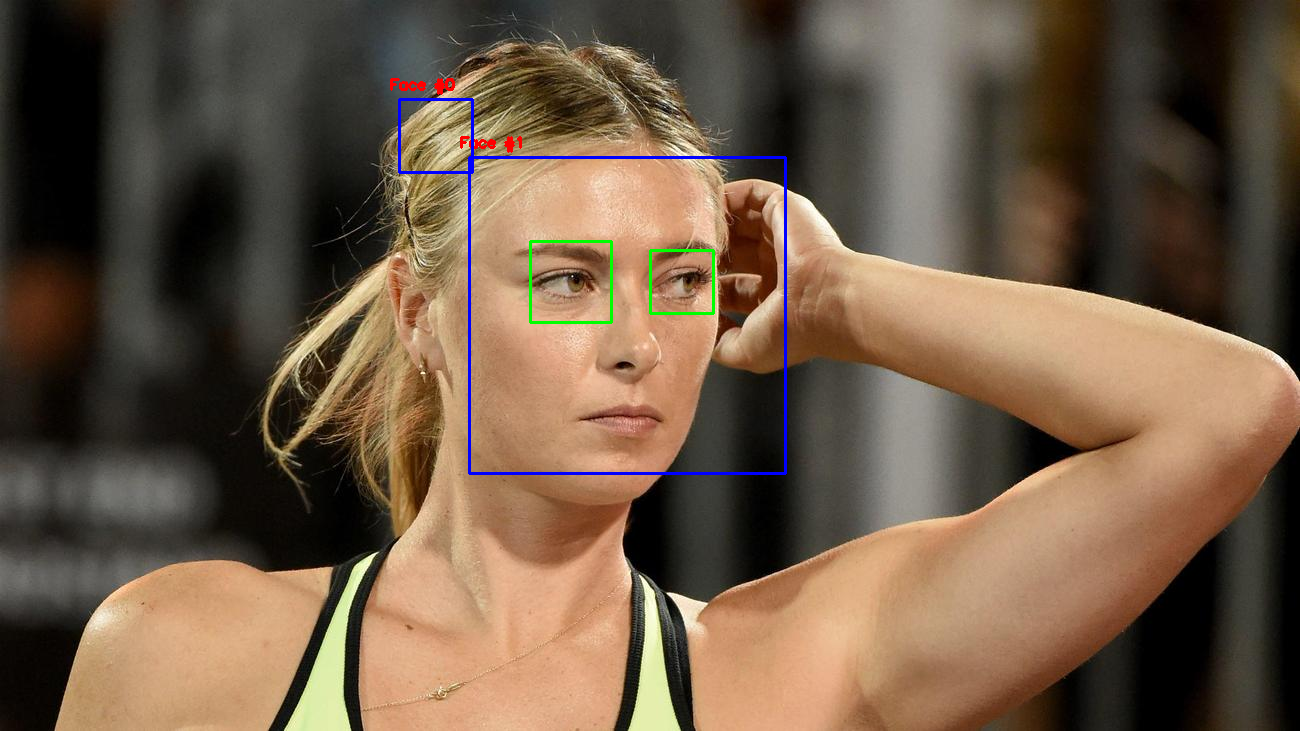

In [11]:
#EYES
if len(faces) >= 1:
    i = 0
    j = 0
    for f in faces:
        face = faces[i]
        (x, y, w, h) = face
        face_img= cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_color=face_img[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for(ex,ey,ew,eh) in eyes:
            if j <2:
              cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
              j=j+1
              cv2_imshow(face_img)
        i=i+1



(316, 316, 3)

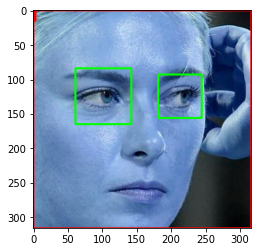

In [12]:
#Crop
#for multiple faces in an image we can crop all faces, save and check there maching faces.
#for false positive case we can avoid by taking an if case with absence of eye 
plt.imshow(roi_color)
cropped_img=np.array(roi_color)
cropped_img.shape

Wavelet Transformation

In [13]:
import numpy as np
import pywt
import cv2
def w2d(img, mode='haar', level=1) :
    imArray=img
    #datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray=np.float32(imArray)
    imArray /= 255;
    #compute coefficients
    coeffs=pywt.wavedec2(imArray, mode,level=level)
    
    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0]*=0;
    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *=255;
    imArray_H = np.uint8(imArray_H)
    return imArray_H

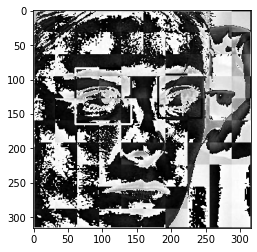

In [14]:
#convert to wavelet transformed image to make it easy to extract
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            return roi_color

In [16]:
path_to_data = f"/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/"
path_to_cr_data = "/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/"

In [17]:
import os
img_dirs=[]
for entry in os.scandir(path_to_data):
    if entry.is_dir():
      img_dirs.append(entry.path)


In [18]:
img_dirs.remove('/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped')
img_dirs

['/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/mariasharapova',
 '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/virat_kohli',
 '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/serena_williams',
 '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/roger_federer',
 '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/lionel_messi']

In [66]:
import shutil
if os.path.exists(path_to_cr_data):
  shutil.rmtree(path_to_cr_data )
os.mkdir(path_to_cr_data )

In [19]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  /content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/mariasharapova
Generating cropped images in folder:  /content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/virat_kohli
Generating cropped images in folder:  /content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/serena_williams
Generating cropped images in folder:  /content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/roger_federer
Generating cropped images in folder:  /content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/lionel_messi


In [92]:
#create dictionary
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'mariasharapova': ['/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/mariasharapova/mariasharapova1.png',
  '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/mariasharapova/mariasharapova2.png',
  '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/mariasharapova/mariasharapova3.png',
  '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/mariasharapova/mariasharapova4.png',
  '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/mariasharapova/mariasharapova5.png',
  '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/mariasharapova/mariasharapova6.png',
  '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/mariasharapova/mariasharapova7.png',
  '/content/gdrive/MyDrive/Colab Notebooks/Celebrity Image Classifier/Images/Cropped/mariasharapova/mariasharapova8.png',
  '/co

In [93]:
#for ease of identification 
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'mariasharapova': 0,
 'virat_kohli': 1,
 'serena_williams': 2,
 'roger_federer': 3,
 'lionel_messi': 4}

In [94]:
# We will use raw images along with wavelet transformed images to train our classifier.
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [95]:
len(X[0])

4096

In [96]:
32*32*3 + 32*32

4096

In [97]:
print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [98]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(160, 4096)

Training

In [99]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.775

In [101]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.80      0.67      0.73        12
           2       1.00      0.50      0.67         6
           3       0.71      0.83      0.77         6
           4       0.71      1.00      0.83        10

    accuracy                           0.78        40
   macro avg       0.81      0.77      0.77        40
weighted avg       0.80      0.78      0.77        40



GridSearch

In [102]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [104]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [105]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

model  best_score  \
0                  svm    0.850000   
1        random_forest    0.708333   
2  logistic_regression    0.858333   

                                    best_params  
0        {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 10}  
2                  {'logisticregression__C': 1}

In [107]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [108]:
best_estimators['svm'].score(X_test,y_test)

0.825

In [109]:
best_estimators['random_forest'].score(X_test,y_test)

0.775

In [110]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.9

In [111]:
best_clf = best_estimators['logistic_regression']

In [112]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 6,  0,  0,  0,  0],
       [ 0, 11,  1,  0,  0],
       [ 0,  0,  5,  1,  0],
       [ 0,  0,  0,  5,  1],
       [ 0,  0,  1,  0,  9]])

Text(69.0, 0.5, 'Truth')

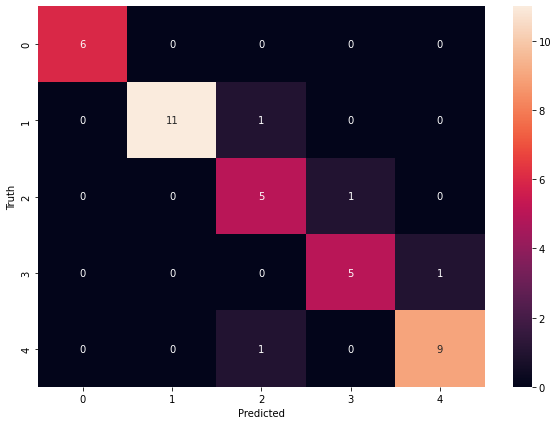

In [113]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Saving trained model

In [114]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


['saved_model.pkl']

Saving class dictionary

In [115]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))